In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import scipy
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import pathlib
import sklearn.metrics
from scipy.stats import gaussian_kde
import matplotlib.cm as cm

import random
import time

In [2]:

def model_outcomes_coal(model, coal, local_obs, ref_point, imp=None, predict_proba=False, seed=0):
    
    start = time.time()
    
    ## this function outputs a list of all model predictions for a single coalition
    # the input is the coalition of interest as a binary vector eg. [1,1,0,1]
    # ref point is the entire reference distirbution (here we take x_train)
    # local_obs is the instance we aim to explain
    
    n_obs, d_obs = np.shape(local_obs)

    # we consider all 2**n coalitions and all n reference points
    # get constants
    
    n, d = np.shape(ref_point)
    assert d == d_obs
    
    # train imputation algorithm for conditional references   
    # create an "all_imputed_coalitions" 3D matrix with all "artificial inputs" we get by imputing
    coalitions = np.array([[int(i) for i in '0'*((d)-len(bin(j))+2) + bin(j)[2:]] for j in range(2**d)]) 
    all_imputed_coalitions = np.zeros((n_obs, n, d))
    
    
    
    
     ## below we build the concatenated inputs using conditional imputation for dropped features and averages
    for k in range(n):#reference point index
        vect=(1-coal) 
        vect = vect.astype('float')
        vect[vect == 1] = 'nan'    # vect is a binary vector of being "absent" ('nan') or "present" (1)
        # impute conditionally with Bayesian Ridge MICE 
        imputed_coalitions = coal * local_obs + vect #either local obs value or 'nan'
        #print(imputed_coalitions)
        nans = (np.isnan(imputed_coalitions).sum(axis=0) > 0)
        if imp is None:
            idx = np.random.randint(n, size=n_obs)
            imputation = ref_point[idx]
            imputed_coalitions[:,nans] = imputation[:,nans]
        else:
            imputed_coalitions = imp.transform(imputed_coalitions)
        all_imputed_coalitions[:, k, :] = imputed_coalitions
        
    end = time.time()
    print('Execution time (s) :', end - start)
    #we ultimately return the model predictions
    if predict_proba:
        outputs = model.predict_proba(all_imputed_coalitions.reshape(n_obs * n, d))[:,1].reshape(n_obs, n)
        obs = coal * local_obs + vect
        return outputs
    else:
        return model.predict(all_imputed_coalitions.reshape(n_obs * n, d)).reshape(n_obs, n)


In [3]:
np.random.seed(0)
N = 500
p = 0.5 * np.ones(N)
t = np.random.binomial(n=1, p=p)

q = np.random.uniform(size=N)
prob = 0.99
delta_prob = 2*prob - 1
d = np.random.binomial(n=1, p=prob - delta_prob * t)

q_mean = np.mean(q)
d_mean = np.mean(d)
t_mean = np.mean(t)

In [4]:
class ModelWrapper(object):
    
    def __init__(self, func):
        self.func = func
        
    def predict_proba(self, x):
        probas = self.func(x).reshape(-1,1)
        probas_sklearn = np.hstack([1 - probas, probas])
        return probas_sklearn
    
    def predict(self, x):
        probs = self.predict_proba(x)
        return (probs[:,1] > probs[:,0])
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

In [5]:
def indep_predict_proba(x):
        x = np.array(x)
        d = x[:,1]
        q = x[:,0]
        t = x[:,2]
        p1 = (1-t)*(prob - delta_prob * d) + t*(1 - prob + delta_prob * d)
        return p1

In [6]:
indep_classifier = ModelWrapper(indep_predict_proba)

In [7]:
x = pd.DataFrame({'q': q, 'd': d, 't': t})
prop_train = 0.5
N_train = int(prop_train * N)
x_train = x.iloc[:N_train]
x_test = x.iloc[N_train:]

In [8]:
imp = IterativeImputer(max_iter=100, random_state=0, sample_posterior=True)
imp.fit(x_train.values) #imputer learns from marginal distribution


imp_all_but_t = IterativeImputer(max_iter=100, random_state=0, sample_posterior=True)
imp_all_but_t.fit(x_train[['q','d']].values)

imp_off = None

In [9]:

x_indep = pd.DataFrame({'q': np.random.permutation(q), 'd': np.random.permutation(d), 't': np.random.permutation(t)})
x_indep_train = x_indep.iloc[:N_train]
x_indep_test = x_indep.iloc[N_train:]


In [10]:
indep_classifier.score(np.vstack([x_train]), np.hstack([np.zeros(len(x_train))]))

0.988

In [11]:
indep_classifier.score(np.vstack([x_indep_train]), np.hstack([np.ones(len(x_indep_train))]))

0.464

In [12]:
indep_classifier.score(np.vstack([x_test]), np.hstack([np.zeros(len(x_test))]))

0.984

In [13]:
indep_classifier.score(np.vstack([x_indep_test]), np.hstack([np.ones(len(x_indep_test))]))

0.492

In [14]:
# x = pd.DataFrame({'q': q, 'd': d, 't': t})
from scipy.special import expit
def predict_proba_unfair(x):
    d = x[:,1]
    t = x[:,2]
    return (t + t*d)/2

unfair_model = ModelWrapper(predict_proba_unfair)

def predict_proba_fair(x):
    q = x[:,0]
    return q

fair_model = ModelWrapper(predict_proba_fair)


def predict_proba_attacker(x):
    fair = predict_proba_fair(x)
    unfair = predict_proba_unfair(x)
    indep = indep_classifier.predict(x)
    return indep*fair + (1 - indep)*unfair

attacker_model = ModelWrapper(predict_proba_attacker)


In [15]:


from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
propensity = LogisticRegression()
propensity.fit(x_train[['q','d']], x_train['t'])



LogisticRegression()

## Off-manifold Shapley

In [16]:
# Unfair
print('unfair_off_all')
unfair_off_all = model_outcomes_coal(model=unfair_model, coal=np.array([1,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)
print('unfair_off_all_but_t')
unfair_off_all_but_t = model_outcomes_coal(model=unfair_model, coal=np.array([1,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)


print('unfair_off_all_but_q')
unfair_off_all_but_q = model_outcomes_coal(model=unfair_model, coal=np.array([0,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)
print('unfair_off_all_but_q_t')
unfair_off_all_but_q_t = model_outcomes_coal(model=unfair_model, coal=np.array([0,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)


print('unfair_off_all_but_d')
unfair_off_all_but_d = model_outcomes_coal(model=unfair_model, coal=np.array([1,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)
print('unfair_off_all_but_d_t')
unfair_off_all_but_d_t = model_outcomes_coal(model=unfair_model, coal=np.array([1,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)

print('unfair_off_all_but_q_d')
unfair_off_all_but_q_d = model_outcomes_coal(model=unfair_model, coal=np.array([0,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)
print('unfair_off_all_but_q_d_t')
unfair_off_all_but_q_d_t = model_outcomes_coal(model=unfair_model, coal=np.array([0,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)

# Attacker
print('attacker_off_all')
attacker_off_all = model_outcomes_coal(model=attacker_model, coal=np.array([1,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)
print('attacker_off_all_but_t')
attacker_off_all_but_t = model_outcomes_coal(model=attacker_model, coal=np.array([1,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)


print('attacker_off_all_but_q')
attacker_off_all_but_q = model_outcomes_coal(model=attacker_model, coal=np.array([0,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)
print('attacker_off_all_but_q_t')
attacker_off_all_but_q_t = model_outcomes_coal(model=attacker_model, coal=np.array([0,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)


print('attacker_off_all_but_d')
attacker_off_all_but_d = model_outcomes_coal(model=attacker_model, coal=np.array([1,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)
print('attacker_off_all_but_d_t')
attacker_off_all_but_d_t = model_outcomes_coal(model=attacker_model, coal=np.array([1,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)


print('attacker_off_all_but_q_d')
attacker_off_all_but_q_d = model_outcomes_coal(model=attacker_model, coal=np.array([0,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)
print('attacker_off_all_but_q_d_t')
attacker_off_all_but_q_d_t = model_outcomes_coal(model=attacker_model, coal=np.array([0,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)

# Fair
print('fair_off_all')
fair_off_all = model_outcomes_coal(model=fair_model, coal=np.array([1,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)
print('fair_off_all_but_t')
fair_off_all_but_t = model_outcomes_coal(model=fair_model, coal=np.array([1,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)


print('fair_off_all_but_q')
fair_off_all_but_q = model_outcomes_coal(model=fair_model, coal=np.array([0,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)
print('fair_off_all_but_q_t')
fair_off_all_but_q_t = model_outcomes_coal(model=fair_model, coal=np.array([0,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)


print('fair_off_all_but_d')
fair_off_all_but_d = model_outcomes_coal(model=fair_model, coal=np.array([1,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)
print('fair_off_all_but_d_t')
fair_off_all_but_d_t = model_outcomes_coal(model=fair_model, coal=np.array([1,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)


print('fair_off_all_but_q_d')
fair_off_all_but_q_d = model_outcomes_coal(model=fair_model, coal=np.array([0,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)
print('fair_off_all_but_q_d_t')
fair_off_all_but_q_d_t = model_outcomes_coal(model=fair_model, coal=np.array([0,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp_off, predict_proba=True)


unfair_off_all
Execution time (s) : 0.02027606964111328
unfair_off_all_but_t
Execution time (s) : 0.020261049270629883
unfair_off_all_but_q
Execution time (s) : 0.015908002853393555
unfair_off_all_but_q_t
Execution time (s) : 0.013063430786132812
unfair_off_all_but_d
Execution time (s) : 0.013270139694213867
unfair_off_all_but_d_t
Execution time (s) : 0.011687040328979492
unfair_off_all_but_q_d
Execution time (s) : 0.011273384094238281
unfair_off_all_but_q_d_t
Execution time (s) : 0.012029409408569336
attacker_off_all
Execution time (s) : 0.00996851921081543
attacker_off_all_but_t
Execution time (s) : 0.010831594467163086
attacker_off_all_but_q
Execution time (s) : 0.012934446334838867
attacker_off_all_but_q_t
Execution time (s) : 0.010709285736083984
attacker_off_all_but_d
Execution time (s) : 0.011002302169799805
attacker_off_all_but_d_t
Execution time (s) : 0.013921499252319336
attacker_off_all_but_q_d
Execution time (s) : 0.012266159057617188
attacker_off_all_but_q_d_t
Execution ti

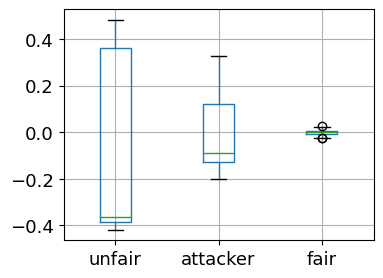

In [17]:
unfair_off = 1/3*(unfair_off_all - unfair_off_all_but_t) + 1/6*(unfair_off_all_but_q - unfair_off_all_but_q_t) + 1/6*(unfair_off_all_but_d - unfair_off_all_but_d_t) + 1/3*(unfair_off_all_but_q_d - unfair_off_all_but_q_d_t)
unfair_off = unfair_off.mean(axis=1)

attacker_off = 1/3*(attacker_off_all - attacker_off_all_but_t) + 1/6*(attacker_off_all_but_q - attacker_off_all_but_q_t) + 1/6*(attacker_off_all_but_d - attacker_off_all_but_d_t) + 1/3*(attacker_off_all_but_q_d - attacker_off_all_but_q_d_t)
attacker_off = attacker_off.mean(axis=1)

fair_off = 1/3*(fair_off_all - fair_off_all_but_t) + 1/6*(fair_off_all_but_q - fair_off_all_but_q_t) + 1/6*(fair_off_all_but_d - fair_off_all_but_d_t) + 1/3*(fair_off_all_but_q_d - fair_off_all_but_q_d_t)
fair_off = fair_off.mean(axis=1)

df_off = pd.DataFrame({
    'unfair': unfair_off,
    'attacker': attacker_off,
    'fair': fair_off
})
df_off.boxplot(fontsize=13, figsize=(4,3))
plt.show()

## Observational Shapley

In [18]:
# Full coalition
print('unfair_on_all')
unfair_on_all = model_outcomes_coal(model=unfair_model, coal=np.array([1,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('unfair_on_all_but_t')
unfair_on_all_but_t = model_outcomes_coal(model=unfair_model, coal=np.array([1,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


unfair_on_all
Execution time (s) : 0.42164039611816406
unfair_on_all_but_t
Execution time (s) : 488.25350046157837


In [19]:
print('unfair_on_all_but_q')
unfair_on_all_but_q = model_outcomes_coal(model=unfair_model, coal=np.array([0,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('unfair_on_all_but_q_t')
unfair_on_all_but_q_t = model_outcomes_coal(model=unfair_model, coal=np.array([0,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


unfair_on_all_but_q
Execution time (s) : 510.01944398880005
unfair_on_all_but_q_t
Execution time (s) : 1048.646456003189


In [20]:
print('unfair_on_all_but_d')
unfair_on_all_but_d = model_outcomes_coal(model=unfair_model, coal=np.array([1,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('unfair_on_all_but_d_t')
unfair_on_all_but_d_t = model_outcomes_coal(model=unfair_model, coal=np.array([1,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


unfair_on_all_but_d
Execution time (s) : 535.6945173740387
unfair_on_all_but_d_t
Execution time (s) : 1097.192411184311


In [21]:
print('unfair_on_all_but_q_d')
unfair_on_all_but_q_d = model_outcomes_coal(model=unfair_model, coal=np.array([0,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('unfair_on_all_but_q_d_t')
unfair_on_all_but_q_d_t = model_outcomes_coal(model=unfair_model, coal=np.array([0,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


unfair_on_all_but_q_d
Execution time (s) : 967.6444959640503
unfair_on_all_but_q_d_t
Execution time (s) : 0.057219505310058594


In [22]:
# Attacker
print('attacker_on_all')
attacker_on_all = model_outcomes_coal(model=attacker_model, coal=np.array([1,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('attacker_on_all_but_t')
attacker_on_all_but_t = model_outcomes_coal(model=attacker_model, coal=np.array([1,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


print('attacker_on_all_but_q')
attacker_on_all_but_q = model_outcomes_coal(model=attacker_model, coal=np.array([0,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('attacker_on_all_but_q_t')
attacker_on_all_but_q_t = model_outcomes_coal(model=attacker_model, coal=np.array([0,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


print('attacker_on_all_but_d')
attacker_on_all_but_d = model_outcomes_coal(model=attacker_model, coal=np.array([1,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('attacker_on_all_but_d_t')
attacker_on_all_but_d_t = model_outcomes_coal(model=attacker_model, coal=np.array([1,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


print('attacker_on_all_but_q_d')
attacker_on_all_but_q_d = model_outcomes_coal(model=attacker_model, coal=np.array([0,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('attacker_on_all_but_q_d_t')
attacker_on_all_but_q_d_t = model_outcomes_coal(model=attacker_model, coal=np.array([0,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


attacker_on_all
Execution time (s) : 0.41375041007995605
attacker_on_all_but_t
Execution time (s) : 467.2988336086273
attacker_on_all_but_q
Execution time (s) : 512.8583076000214
attacker_on_all_but_q_t
Execution time (s) : 984.4770331382751
attacker_on_all_but_d
Execution time (s) : 493.1918559074402
attacker_on_all_but_d_t
Execution time (s) : 1060.6040165424347
attacker_on_all_but_q_d
Execution time (s) : 1088.1881787776947
attacker_on_all_but_q_d_t
Execution time (s) : 0.07605886459350586


In [23]:
# Fair
print('fair_on_all')
fair_on_all = model_outcomes_coal(model=fair_model, coal=np.array([1,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('fair_on_all_but_t')
fair_on_all_but_t = model_outcomes_coal(model=fair_model, coal=np.array([1,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


print('fair_on_all_but_q')
fair_on_all_but_q = model_outcomes_coal(model=fair_model, coal=np.array([0,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('fair_on_all_but_q_t')
fair_on_all_but_q_t = model_outcomes_coal(model=fair_model, coal=np.array([0,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


print('fair_on_all_but_d')
fair_on_all_but_d = model_outcomes_coal(model=fair_model, coal=np.array([1,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('fair_on_all_but_d_t')
fair_on_all_but_d_t = model_outcomes_coal(model=fair_model, coal=np.array([1,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


print('fair_on_all_but_q_d')
fair_on_all_but_q_d = model_outcomes_coal(model=fair_model, coal=np.array([0,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('fair_on_all_but_q_d_t')
fair_on_all_but_q_d_t = model_outcomes_coal(model=fair_model, coal=np.array([0,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


fair_on_all
Execution time (s) : 0.5582699775695801
fair_on_all_but_t
Execution time (s) : 544.4142117500305
fair_on_all_but_q
Execution time (s) : 545.5060021877289
fair_on_all_but_q_t
Execution time (s) : 1035.38884973526
fair_on_all_but_d
Execution time (s) : 448.3011326789856
fair_on_all_but_d_t
Execution time (s) : 874.2565083503723
fair_on_all_but_q_d
Execution time (s) : 895.2662060260773
fair_on_all_but_q_d_t
Execution time (s) : 0.05764031410217285


In [24]:
unfair_on = 1/3*(unfair_on_all - unfair_on_all_but_t) + 1/6*(unfair_on_all_but_q - unfair_on_all_but_q_t) + 1/6*(unfair_on_all_but_d - unfair_on_all_but_d_t) + 1/3*(unfair_on_all_but_q_d - unfair_on_all_but_q_d_t)
unfair_on = unfair_on.mean(axis=1)

In [25]:
attacker_on = 1/3*(attacker_on_all - attacker_on_all_but_t) + 1/6*(attacker_on_all_but_q - attacker_on_all_but_q_t) + 1/6*(attacker_on_all_but_d - attacker_on_all_but_d_t) + 1/3*(attacker_on_all_but_q_d - attacker_on_all_but_q_d_t)
attacker_on = attacker_on.mean(axis=1)

In [26]:
fair_on = 1/3*(fair_on_all - fair_on_all_but_t) + 1/6*(fair_on_all_but_q - fair_on_all_but_q_t) + 1/6*(fair_on_all_but_d - fair_on_all_but_d_t) + 1/3*(fair_on_all_but_q_d - fair_on_all_but_q_d_t)
fair_on = fair_on.mean(axis=1)

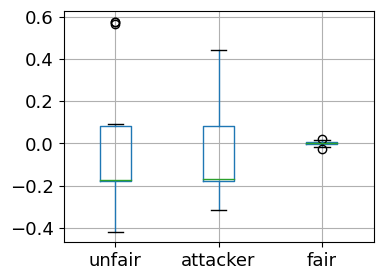

In [27]:
df_on = pd.DataFrame({
    'unfair': unfair_on,
    'attacker': attacker_on,
    'fair': fair_on
})
df_on.boxplot(fontsize=13, figsize=(4,3))
plt.show()

## PWSHAP

In [28]:
propensities_all =  model_outcomes_coal(model=propensity, coal=np.array([1,1]), local_obs=x_test[['q','d']].values, ref_point=x_train[['q','d']].values, imp=imp_all_but_t, predict_proba=True)
propensities_all_but_d =  model_outcomes_coal(model=propensity, coal=np.array([1,0]), local_obs=x_test[['q','d']].values, ref_point=x_train[['q','d']].values, imp=imp_all_but_t, predict_proba=True)
propensities_all_but_q_d =  model_outcomes_coal(model=propensity, coal=np.array([0,0]), local_obs=x_test[['q','d']].values, ref_point=x_train[['q','d']].values, imp=imp_all_but_t, predict_proba=True)


Execution time (s) : 0.2997324466705322


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 465.73522210121155
Execution time (s) : 0.07220840454101562


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [29]:

unfair_pwshap_t_y = (unfair_on_all_but_q_d - unfair_on_all_but_q_d_t).mean(axis=1) / (x_test['t'].values - propensities_all_but_q_d.mean(axis=1))

unfair_pwshap_t_d_y = (unfair_on_all - unfair_on_all_but_t).mean(axis=1) / (x_test['t'].values - propensities_all.mean(axis=1)) - (unfair_on_all_but_d - unfair_on_all_but_d_t).mean(axis=1) / (x_test['t'].values - propensities_all_but_d.mean(axis=1))

In [30]:


attacker_pwshap_t_y = (attacker_on_all_but_q_d - attacker_on_all_but_q_d_t).mean(axis=1) / (x_test['t'].values - propensities_all_but_q_d.mean(axis=1))

attacker_pwshap_t_d_y = (attacker_on_all - attacker_on_all_but_t).mean(axis=1) / (x_test['t'].values - propensities_all.mean(axis=1)) - (attacker_on_all_but_d - attacker_on_all_but_d_t).mean(axis=1) / (x_test['t'].values - propensities_all_but_d.mean(axis=1))

In [31]:

fair_pwshap_t_y = (fair_on_all_but_q_d - fair_on_all_but_q_d_t).mean(axis=1) / (x_test['t'].values - propensities_all_but_q_d.mean(axis=1))

fair_pwshap_t_d_y = (fair_on_all - fair_on_all_but_t).mean(axis=1) / (x_test['t'].values - propensities_all.mean(axis=1)) - (fair_on_all_but_d - fair_on_all_but_d_t).mean(axis=1) / (x_test['t'].values - propensities_all_but_d.mean(axis=1))

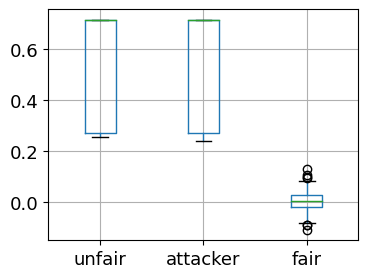

In [32]:

df_pwshap_t_y = pd.DataFrame({
    'unfair': unfair_pwshap_t_y,
    'attacker': attacker_pwshap_t_y,
    'fair': fair_pwshap_t_y
})
df_pwshap_t_y.boxplot(fontsize=13, figsize=(4,3))
plt.show()

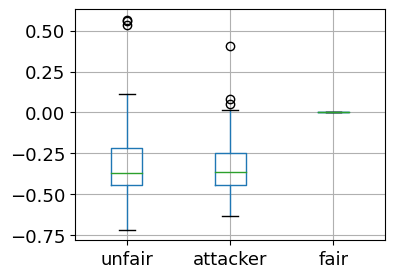

In [33]:

df_pwshap_t_d_y = pd.DataFrame({
    'unfair': unfair_pwshap_t_d_y,
    'attacker': attacker_pwshap_t_d_y,
    'fair': fair_pwshap_t_d_y
})
df_pwshap_t_d_y.boxplot(fontsize=13, figsize=(4,3))
plt.show()